In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.layers import Dense, Input, Dropout, Activation, Conv2D, MaxPooling2D, Lambda, Flatten, GlobalAveragePooling2D
from keras.layers.merge import concatenate

from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data-ISBI-resized/train/'
validation_dir = 'data-ISBI-resized/validation/'
test_dir = 'data-ISBI-resized/test/'

extracted_features_dir = "extracted_features/"
model_name = "MobileNet_Plain_SGD"

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data-ISBI-resized/train/ 0
data-ISBI-resized/train/malignant 40425
data-ISBI-resized/train/normal 18747
******************************
data-ISBI-resized/test/ 0
data-ISBI-resized/test/malignant 655
data-ISBI-resized/test/normal 312


In [5]:
batch_size = 32
img_height, img_width = 380, 380
input_shape = (img_height, img_width, 3)
epochs = 1000

top_model_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_weights.h5')

In [6]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
#     validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 59170 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [7]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 59170
nb_validation_samples: 18384
nb_test_samples: 967

predict_size_train: 1850
predict_size_validation: 575
predict_size_test: 31

 num_classes: 2


In [8]:
bottleneck_final_model = MobileNet(include_top=False, weights='imagenet', pooling='avg')

In [9]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [10]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [11]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [12]:
import tensorflow as tf
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [13]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [14]:
model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

sgd_opt=SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)
# adam_opt=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.999, amsgrad=True)
model.compile(optimizer=sgd_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 59168 samples, validate on 18384 samples
Epoch 1/1000
 - 6s - loss: 0.5159 - acc: 0.7606 - val_loss: 0.4605 - val_acc: 0.8079
Epoch 2/1000
 - 5s - loss: 0.4646 - acc: 0.7990 - val_loss: 0.4467 - val_acc: 0.8146
Epoch 3/1000
 - 5s - loss: 0.4503 - acc: 0.8082 - val_loss: 0.4368 - val_acc: 0.8208
Epoch 4/1000
 - 5s - loss: 0.4406 - acc: 0.8140 - val_loss: 0.4332 - val_acc: 0.8209
Epoch 5/1000
 - 5s - loss: 0.4330 - acc: 0.8169 - val_loss: 0.4234 - val_acc: 0.8283
Epoch 6/1000
 - 5s - loss: 0.4262 - acc: 0.8208 - val_loss: 0.4185 - val_acc: 0.8305
Epoch 7/1000
 - 5s - loss: 0.4206 - acc: 0.8252 - val_loss: 0.4132 - val_acc: 0.8330
Epoch 8/1000
 - 5s - loss: 0.4144 - acc: 0.8268 - val_loss: 0.4103 - val_acc: 0.8337
Epoch 9/1000
 - 5s - loss: 0.4108 - acc: 0.8279 - val_loss: 0.4050 - val_acc: 0.8381
Epoch 10/1000
 - 5s - loss: 0.4052 - acc: 0.8317 - val_loss: 0.4020 - val_acc: 0.8375
Epoch 11/1000
 - 5s - loss: 0.4019 - acc: 0.8323 - val_loss: 0.3977 - val_acc: 0.8405
Epoch 12/1000

Epoch 96/1000
 - 5s - loss: 0.2870 - acc: 0.8856 - val_loss: 0.3210 - val_acc: 0.8703
Epoch 97/1000
 - 5s - loss: 0.2868 - acc: 0.8859 - val_loss: 0.3205 - val_acc: 0.8685
Epoch 98/1000
 - 5s - loss: 0.2856 - acc: 0.8860 - val_loss: 0.3204 - val_acc: 0.8702
Epoch 99/1000
 - 5s - loss: 0.2855 - acc: 0.8858 - val_loss: 0.3220 - val_acc: 0.8693
Epoch 100/1000
 - 5s - loss: 0.2849 - acc: 0.8863 - val_loss: 0.3199 - val_acc: 0.8703
Epoch 101/1000
 - 5s - loss: 0.2844 - acc: 0.8866 - val_loss: 0.3212 - val_acc: 0.8693
Epoch 102/1000
 - 5s - loss: 0.2830 - acc: 0.8884 - val_loss: 0.3194 - val_acc: 0.8701
Epoch 103/1000
 - 5s - loss: 0.2824 - acc: 0.8878 - val_loss: 0.3216 - val_acc: 0.8680
Epoch 104/1000
 - 5s - loss: 0.2833 - acc: 0.8871 - val_loss: 0.3190 - val_acc: 0.8711
Epoch 105/1000
 - 5s - loss: 0.2814 - acc: 0.8870 - val_loss: 0.3212 - val_acc: 0.8701
Epoch 106/1000
 - 5s - loss: 0.2806 - acc: 0.8894 - val_loss: 0.3182 - val_acc: 0.8716
Epoch 107/1000
 - 5s - loss: 0.2793 - acc: 0.88

Epoch 191/1000
 - 5s - loss: 0.2269 - acc: 0.9112 - val_loss: 0.3076 - val_acc: 0.8764
Epoch 192/1000
 - 5s - loss: 0.2246 - acc: 0.9120 - val_loss: 0.3053 - val_acc: 0.8780
Epoch 193/1000
 - 5s - loss: 0.2248 - acc: 0.9104 - val_loss: 0.3050 - val_acc: 0.8776
Epoch 194/1000
 - 5s - loss: 0.2259 - acc: 0.9109 - val_loss: 0.3075 - val_acc: 0.8753
Epoch 195/1000
 - 5s - loss: 0.2239 - acc: 0.9121 - val_loss: 0.3032 - val_acc: 0.8773
Epoch 196/1000
 - 5s - loss: 0.2243 - acc: 0.9113 - val_loss: 0.3064 - val_acc: 0.8764
Epoch 197/1000
 - 5s - loss: 0.2223 - acc: 0.9127 - val_loss: 0.3022 - val_acc: 0.8786
Epoch 198/1000
 - 5s - loss: 0.2218 - acc: 0.9135 - val_loss: 0.3033 - val_acc: 0.8786
Epoch 199/1000
 - 5s - loss: 0.2226 - acc: 0.9135 - val_loss: 0.3043 - val_acc: 0.8771
Epoch 200/1000
 - 5s - loss: 0.2216 - acc: 0.9122 - val_loss: 0.3058 - val_acc: 0.8770
Epoch 201/1000
 - 5s - loss: 0.2214 - acc: 0.9128 - val_loss: 0.3059 - val_acc: 0.8778
Epoch 202/1000
 - 5s - loss: 0.2197 - acc: 

 - 5s - loss: 0.1821 - acc: 0.9294 - val_loss: 0.3046 - val_acc: 0.8809
Epoch 286/1000
 - 6s - loss: 0.1819 - acc: 0.9297 - val_loss: 0.3015 - val_acc: 0.8823
Epoch 287/1000
 - 5s - loss: 0.1810 - acc: 0.9290 - val_loss: 0.3065 - val_acc: 0.8803
Epoch 288/1000
 - 5s - loss: 0.1800 - acc: 0.9311 - val_loss: 0.3028 - val_acc: 0.8815
Epoch 289/1000
 - 5s - loss: 0.1802 - acc: 0.9313 - val_loss: 0.2998 - val_acc: 0.8809
Epoch 290/1000
 - 5s - loss: 0.1773 - acc: 0.9323 - val_loss: 0.3045 - val_acc: 0.8810
Epoch 291/1000
 - 5s - loss: 0.1779 - acc: 0.9311 - val_loss: 0.3033 - val_acc: 0.8817
Epoch 292/1000
 - 5s - loss: 0.1784 - acc: 0.9311 - val_loss: 0.3081 - val_acc: 0.8808
Epoch 293/1000
 - 5s - loss: 0.1782 - acc: 0.9315 - val_loss: 0.3014 - val_acc: 0.8807
Epoch 294/1000
 - 5s - loss: 0.1770 - acc: 0.9320 - val_loss: 0.3029 - val_acc: 0.8817
Epoch 295/1000
 - 5s - loss: 0.1765 - acc: 0.9324 - val_loss: 0.3106 - val_acc: 0.8797
Epoch 296/1000
 - 5s - loss: 0.1767 - acc: 0.9312 - val_lo

Epoch 380/1000
 - 5s - loss: 0.1467 - acc: 0.9452 - val_loss: 0.3070 - val_acc: 0.8827
Epoch 381/1000
 - 5s - loss: 0.1480 - acc: 0.9451 - val_loss: 0.3076 - val_acc: 0.8833
Epoch 382/1000
 - 5s - loss: 0.1465 - acc: 0.9452 - val_loss: 0.3132 - val_acc: 0.8848
Epoch 383/1000
 - 5s - loss: 0.1472 - acc: 0.9441 - val_loss: 0.3075 - val_acc: 0.8842
Epoch 384/1000
 - 5s - loss: 0.1443 - acc: 0.9452 - val_loss: 0.3064 - val_acc: 0.8842
Epoch 385/1000
 - 6s - loss: 0.1471 - acc: 0.9454 - val_loss: 0.3181 - val_acc: 0.8820
Epoch 386/1000
 - 5s - loss: 0.1453 - acc: 0.9449 - val_loss: 0.3110 - val_acc: 0.8834
Epoch 387/1000
 - 5s - loss: 0.1452 - acc: 0.9465 - val_loss: 0.3097 - val_acc: 0.8837
Epoch 388/1000
 - 5s - loss: 0.1458 - acc: 0.9445 - val_loss: 0.3072 - val_acc: 0.8829
Epoch 389/1000
 - 5s - loss: 0.1438 - acc: 0.9468 - val_loss: 0.3116 - val_acc: 0.8830
Epoch 390/1000
 - 5s - loss: 0.1423 - acc: 0.9473 - val_loss: 0.3115 - val_acc: 0.8821
Epoch 391/1000
 - 5s - loss: 0.1439 - acc: 

 - 5s - loss: 0.1239 - acc: 0.9539 - val_loss: 0.3178 - val_acc: 0.8857
Epoch 475/1000
 - 5s - loss: 0.1236 - acc: 0.9546 - val_loss: 0.3197 - val_acc: 0.8851
Epoch 476/1000
 - 5s - loss: 0.1219 - acc: 0.9557 - val_loss: 0.3153 - val_acc: 0.8846
Epoch 477/1000
 - 5s - loss: 0.1214 - acc: 0.9560 - val_loss: 0.3114 - val_acc: 0.8855
Epoch 478/1000
 - 5s - loss: 0.1191 - acc: 0.9566 - val_loss: 0.3160 - val_acc: 0.8859
Epoch 479/1000
 - 5s - loss: 0.1214 - acc: 0.9556 - val_loss: 0.3111 - val_acc: 0.8862
Epoch 480/1000
 - 5s - loss: 0.1213 - acc: 0.9558 - val_loss: 0.3173 - val_acc: 0.8852
Epoch 481/1000
 - 5s - loss: 0.1205 - acc: 0.9564 - val_loss: 0.3149 - val_acc: 0.8864
Epoch 482/1000
 - 5s - loss: 0.1183 - acc: 0.9568 - val_loss: 0.3156 - val_acc: 0.8853
Epoch 483/1000
 - 5s - loss: 0.1196 - acc: 0.9562 - val_loss: 0.3155 - val_acc: 0.8860
Epoch 484/1000
 - 5s - loss: 0.1197 - acc: 0.9568 - val_loss: 0.3251 - val_acc: 0.8843
Epoch 485/1000
 - 5s - loss: 0.1186 - acc: 0.9577 - val_lo

Epoch 569/1000
 - 5s - loss: 0.1013 - acc: 0.9637 - val_loss: 0.3247 - val_acc: 0.8882
Epoch 570/1000
 - 5s - loss: 0.1024 - acc: 0.9631 - val_loss: 0.3235 - val_acc: 0.8871
Epoch 571/1000
 - 5s - loss: 0.1019 - acc: 0.9637 - val_loss: 0.3192 - val_acc: 0.8870
Epoch 572/1000
 - 5s - loss: 0.1004 - acc: 0.9638 - val_loss: 0.3322 - val_acc: 0.8871
Epoch 573/1000
 - 5s - loss: 0.1006 - acc: 0.9645 - val_loss: 0.3309 - val_acc: 0.8873
Epoch 574/1000
 - 5s - loss: 0.1010 - acc: 0.9651 - val_loss: 0.3214 - val_acc: 0.8869
Epoch 575/1000
 - 5s - loss: 0.1008 - acc: 0.9646 - val_loss: 0.3292 - val_acc: 0.8875
Epoch 576/1000
 - 5s - loss: 0.1013 - acc: 0.9644 - val_loss: 0.3229 - val_acc: 0.8888
Epoch 577/1000
 - 5s - loss: 0.1012 - acc: 0.9642 - val_loss: 0.3323 - val_acc: 0.8875
Epoch 578/1000
 - 5s - loss: 0.1012 - acc: 0.9636 - val_loss: 0.3294 - val_acc: 0.8865
Epoch 579/1000
 - 5s - loss: 0.0997 - acc: 0.9653 - val_loss: 0.3477 - val_acc: 0.8861
Epoch 580/1000
 - 5s - loss: 0.1001 - acc: 

 - 5s - loss: 0.0868 - acc: 0.9704 - val_loss: 0.3352 - val_acc: 0.8875
Epoch 664/1000
 - 5s - loss: 0.0862 - acc: 0.9702 - val_loss: 0.3371 - val_acc: 0.8884
Epoch 665/1000
 - 5s - loss: 0.0867 - acc: 0.9709 - val_loss: 0.3392 - val_acc: 0.8888
Epoch 666/1000
 - 5s - loss: 0.0856 - acc: 0.9705 - val_loss: 0.3399 - val_acc: 0.8879
Epoch 667/1000
 - 5s - loss: 0.0882 - acc: 0.9702 - val_loss: 0.3346 - val_acc: 0.8875
Epoch 668/1000
 - 5s - loss: 0.0863 - acc: 0.9707 - val_loss: 0.3393 - val_acc: 0.8894
Epoch 669/1000
 - 5s - loss: 0.0862 - acc: 0.9705 - val_loss: 0.3364 - val_acc: 0.8852
Epoch 670/1000
 - 5s - loss: 0.0853 - acc: 0.9711 - val_loss: 0.3402 - val_acc: 0.8871
Epoch 671/1000
 - 5s - loss: 0.0845 - acc: 0.9708 - val_loss: 0.3352 - val_acc: 0.8878
Epoch 672/1000
 - 5s - loss: 0.0859 - acc: 0.9701 - val_loss: 0.3366 - val_acc: 0.8881
Epoch 673/1000
 - 5s - loss: 0.0857 - acc: 0.9708 - val_loss: 0.3391 - val_acc: 0.8858
Epoch 674/1000
 - 5s - loss: 0.0854 - acc: 0.9708 - val_lo

Epoch 758/1000
 - 5s - loss: 0.0754 - acc: 0.9747 - val_loss: 0.3435 - val_acc: 0.8881
Epoch 759/1000
 - 5s - loss: 0.0749 - acc: 0.9756 - val_loss: 0.3424 - val_acc: 0.8885
Epoch 760/1000
 - 5s - loss: 0.0745 - acc: 0.9751 - val_loss: 0.3481 - val_acc: 0.8892
Epoch 761/1000
 - 5s - loss: 0.0742 - acc: 0.9757 - val_loss: 0.3439 - val_acc: 0.8890
Epoch 762/1000
 - 5s - loss: 0.0744 - acc: 0.9756 - val_loss: 0.3494 - val_acc: 0.8879
Epoch 763/1000
 - 5s - loss: 0.0738 - acc: 0.9751 - val_loss: 0.3563 - val_acc: 0.8876
Epoch 764/1000
 - 5s - loss: 0.0745 - acc: 0.9747 - val_loss: 0.3422 - val_acc: 0.8890
Epoch 765/1000
 - 5s - loss: 0.0734 - acc: 0.9753 - val_loss: 0.3485 - val_acc: 0.8889
Epoch 766/1000
 - 5s - loss: 0.0746 - acc: 0.9754 - val_loss: 0.3499 - val_acc: 0.8885
Epoch 767/1000
 - 5s - loss: 0.0740 - acc: 0.9755 - val_loss: 0.3464 - val_acc: 0.8883
Epoch 768/1000
 - 5s - loss: 0.0741 - acc: 0.9756 - val_loss: 0.3604 - val_acc: 0.8888
Epoch 769/1000
 - 5s - loss: 0.0741 - acc: 

 - 5s - loss: 0.0653 - acc: 0.9789 - val_loss: 0.3589 - val_acc: 0.8883
Epoch 853/1000
 - 5s - loss: 0.0653 - acc: 0.9781 - val_loss: 0.3608 - val_acc: 0.8902
Epoch 854/1000
 - 5s - loss: 0.0650 - acc: 0.9787 - val_loss: 0.3598 - val_acc: 0.8882
Epoch 855/1000
 - 5s - loss: 0.0659 - acc: 0.9781 - val_loss: 0.3568 - val_acc: 0.8887
Epoch 856/1000
 - 5s - loss: 0.0649 - acc: 0.9784 - val_loss: 0.3602 - val_acc: 0.8889
Epoch 857/1000
 - 5s - loss: 0.0659 - acc: 0.9783 - val_loss: 0.3594 - val_acc: 0.8886
Epoch 858/1000
 - 5s - loss: 0.0649 - acc: 0.9789 - val_loss: 0.3534 - val_acc: 0.8890
Epoch 859/1000
 - 5s - loss: 0.0654 - acc: 0.9783 - val_loss: 0.3561 - val_acc: 0.8902
Epoch 860/1000
 - 5s - loss: 0.0636 - acc: 0.9792 - val_loss: 0.3599 - val_acc: 0.8900
Epoch 861/1000
 - 5s - loss: 0.0646 - acc: 0.9791 - val_loss: 0.3478 - val_acc: 0.8884
Epoch 862/1000
 - 5s - loss: 0.0654 - acc: 0.9786 - val_loss: 0.3566 - val_acc: 0.8896
Epoch 863/1000
 - 5s - loss: 0.0640 - acc: 0.9795 - val_lo

Epoch 947/1000
 - 5s - loss: 0.0558 - acc: 0.9828 - val_loss: 0.3645 - val_acc: 0.8887
Epoch 948/1000
 - 5s - loss: 0.0570 - acc: 0.9825 - val_loss: 0.3831 - val_acc: 0.8900
Epoch 949/1000
 - 5s - loss: 0.0572 - acc: 0.9821 - val_loss: 0.3737 - val_acc: 0.8902
Epoch 950/1000
 - 5s - loss: 0.0587 - acc: 0.9810 - val_loss: 0.3658 - val_acc: 0.8889
Epoch 951/1000
 - 5s - loss: 0.0573 - acc: 0.9823 - val_loss: 0.3726 - val_acc: 0.8883
Epoch 952/1000
 - 5s - loss: 0.0577 - acc: 0.9821 - val_loss: 0.3765 - val_acc: 0.8904
Epoch 953/1000
 - 5s - loss: 0.0573 - acc: 0.9821 - val_loss: 0.3646 - val_acc: 0.8878
Epoch 954/1000
 - 5s - loss: 0.0584 - acc: 0.9812 - val_loss: 0.3770 - val_acc: 0.8892
Epoch 955/1000
 - 5s - loss: 0.0579 - acc: 0.9819 - val_loss: 0.3618 - val_acc: 0.8880
Epoch 956/1000
 - 5s - loss: 0.0569 - acc: 0.9822 - val_loss: 0.3741 - val_acc: 0.8896
Epoch 957/1000
 - 5s - loss: 0.0579 - acc: 0.9818 - val_loss: 0.3634 - val_acc: 0.8896
Epoch 958/1000
 - 5s - loss: 0.0568 - acc: 

In [15]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

18384/18384 [==============================] - 1s 33us/step
Validation Accuracy: 88.9959%
Validation Loss: 0.36958634496396575


In [16]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8800413650465356


Confusion Matrix
[[637  18]
 [ 98 214]]


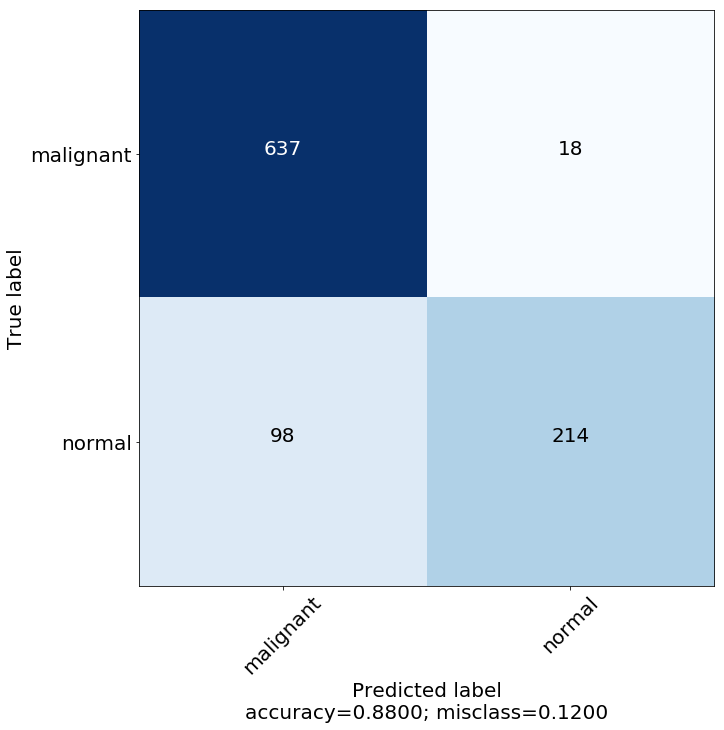

In [17]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[637  18]
 [ 98 214]]
              precision    recall  f1-score   support

   malignant       0.87      0.97      0.92       655
      normal       0.92      0.69      0.79       312

   micro avg       0.88      0.88      0.88       967
   macro avg       0.89      0.83      0.85       967
weighted avg       0.88      0.88      0.87       967



In [19]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  86.66666666666667
Specificity :  92.24137931034483


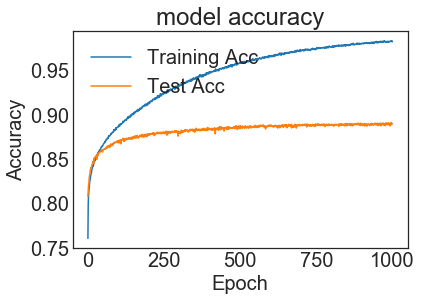

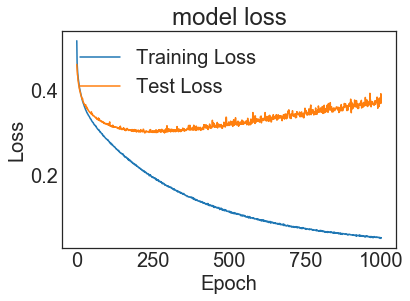

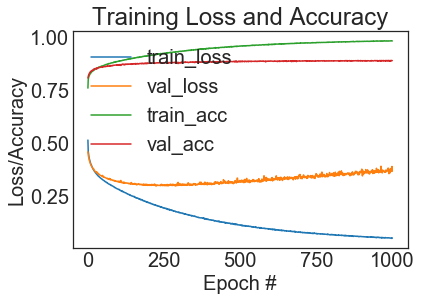

In [20]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [21]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

967/967 [==============================] - 0s 44us/step
Precision =  0.8846533300051113
Recall =  0.8800413650465356
f1_score =  0.8746729242313309


In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.8292082599334507


In [23]:
sample_count = test_generator.samples
print('Sample count: {}'.format(sample_count))

fnames = test_generator.filenames
ground_truth = test_generator.classes
label2index = test_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v, k) for k, v in label2index.items())
predictions = model.predict_classes(test_data)
prob = model.predict(test_data)
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), sample_count))

Sample count: 967
No of errors = 116/967
